In [1]:
from scipy.io import netcdf
from matplotlib import pyplot as plt
from calculations import derive_qbo

In [2]:
nc = netcdf.netcdf_file("data/era-int_pl_1981-mm-u.nc")
sing = netcdf.netcdf_file("data/qbo_index_Singapore_70-10hPa_1976-2017.nc")

In [3]:
u = nc.variables["u"]

my_qbo = derive_qbo(u[:,:,:,:], level=8)

In [4]:
my_qbo

array([ -7.7513685, -10.910168 ,  -6.5878367,  -2.886994 ,  -0.3656919,
         1.4231676,   1.5405283,  -2.5602233,  -6.5917997, -11.20725  ,
       -10.7838   , -13.81741  ], dtype=float32)

In [5]:
ref_qbo = sing.variables["QBO"]

In [6]:
ref_qbo[60:71, 0]

array([2.7192996, 2.6086512, 3.121656 , 3.741617 , 3.3470893, 3.1930585,
       3.225119 , 3.5156088, 3.9079823, 4.14421  , 4.8360047],
      dtype=float32)

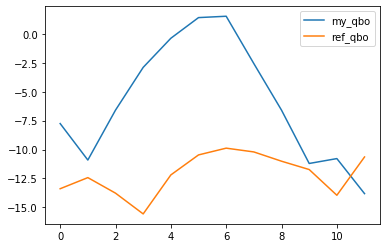

In [7]:
plt.plot(my_qbo, label="my_qbo")
plt.plot(ref_qbo[60:72, -1], label="ref_qbo")
plt.legend()